In [30]:
!ls /keyakizaka_mining/model/facenet

20180402-114759  20180408-102900


In [31]:
!ls /keyakizaka_mining/data/faceimages_pad0/

hamakishihiyori   katoushiho	      odanana		 takamotoayahana
haradaaoi	  kawatayouna	      ozekirika		 takaseaina
higashimuramei	  kobayashiyui	      saitoufuyuyuuhana  tannamameisato
hirateyurina	  koikeminami	      saitoukyouko	 tomitasuzuhana
inokuchimakotoo   kosakanao	      sasakibirei	 tsuchinamamizuho
ishimorinijihana  matsudakouhana      sasakikumi	 watanabemiho
kageyamayuuka	  miyataaihou	      satoushishoku	 watanabenashika
kakizakimemi	  moriyaakane	      shiosarina	 watanaberisa
kamimurarina	  nagahamaneru	      sugaiyuka
kanamurabiku	  nagasawana???kaori  suzuhonbiyu


In [32]:
# path

# save_dir = '/keyakizaka_mining/data/faceimages'
save_dir = '/keyakizaka_mining/data/faceimages_pad0'
#save_feature_dir = '/keyakizaka_mining/data/feature/faceimage'
save_feature_dir = '/keyakizaka_mining/data/feature/faceimage_pad0'
tool_dir = '/keyakizaka_mining/tools'
FACE_MEDEL_PATH = '/keyakizaka_mining/model/facenet/20180408-102900/20180408-102900.pb'

In [33]:
import os, sys
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from annoy import AnnoyIndex
import random

import cloudpickle

def load_from_pkl( fpath ):
    frb = open(fpath, 'rb')
    obj = cloudpickle.loads(frb.read())
    return obj

def save_as_pkl( obj, fpath ):
    fwb = open( fpath, 'wb')
    tmp = fwb.write(cloudpickle.dumps(obj))
    return

In [34]:
from annoy import AnnoyIndex

def get_annoy_index( X, metric ):
    
    doc_num = X.shape[0]
    feature_dim = X.shape[1]
    t = AnnoyIndex( feature_dim, metric=metric ) # AnnoyIndex(f, metric='angular') returns a new index that's read-write and stores vector of f dimensions. Metric can be "angular", "euclidean", "manhattan", "hamming", or "dot"
    for i in range( doc_num ): t.add_item(i, X[:,:feature_dim][i])
    t.build(10)
    
    return t

In [55]:
from scipy import stats
from sklearn.mixture import GaussianMixture

import matplotlib.cm as cm
from matplotlib.patches import Circle
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def get_groups( t_cluster ):
    groups_tmp = {}
    for i, l in enumerate( t_cluster ):
        if not l in groups_tmp: groups_tmp[l] = []
        groups_tmp[l].append( i )
    return groups_tmp

def get_groups_with_dist_from_center( t_cluster, X, gmm ):
    
    centers = np.empty(shape=(gmm.n_components, X.shape[1]))
    for i in range(gmm.n_components):
        density = stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf( X )
        centers[i, :] = X[np.argmax(density)]
    
    groups = {}
    for i, l in enumerate( t_cluster ):
        if not l in groups: groups[l] = {}
        dist = np.linalg.norm( X[i] - centers[l] )
        groups[l][i] = dist

    groups_sorted = {}
    for i, l in enumerate( t_cluster ):
        groups_sorted[l] = [ i for i in sorted( groups[l].items(), key=lambda x:x[1] ) ]
    
    return groups_sorted

def plot_cluster(clutesr_idx, k, images):
    fig, ax = plt.subplots(ncols=k, figsize=(20,20), dpi=100)
    for i in range( k ): # search_k=-1
        im = Image.open( image_list[ targets[ images[i][0] ] ] )
        im_list = np.asarray(im)
        # ax[i].set_title('%s_%f'%(images[i], dists[i]), fontsize=6 )
        ax[i].tick_params(labelbottom=False,bottom=False)
        ax[i].tick_params(labelleft=False,left=False)
        ax[i].spines['top'].set_color( colors[ clutesr_idx ] )
        ax[i].imshow(im_list)
    plt.show()

In [57]:
# load facenet feature

fname = ('facenet',512)

X_face = np.empty((0,fname[1]), float)
image_author = []
image_list = []
dirs = os.listdir( save_dir )
for idx, author in enumerate( dirs ):
    print( idx, len( image_list ), author )
    X_tmp = load_from_pkl( '%s/%s/X_%s_%s.pkl' % (save_feature_dir, fname[0], fname[0], author) )
    X_face = np.append(X_face, X_tmp, axis=0)
    image_list_tmp = load_from_pkl( '%s/%s/resize160_imagelist_%s_%s.pkl' % (save_feature_dir, fname[0], fname[0], author) )
    image_list.extend( image_list_tmp )
    image_author_tmp = [ author for _ in range( len( image_list_tmp ) ) ]
    image_author.extend( image_author_tmp )

20 14308 kanamurabiku
21 14747 ozekirika
22 15439 tomitasuzuhana
23 15639 hirateyurina
24 15976 sasakikumi
25 17122 saitoukyouko
26 20674 moriyaakane
27 22338 shiosarina
28 22876 satoushishoku
29 23415 takamotoayahana
30 24356 inokuchimakotoo
31 25526 watanabenashika
32 25753 kakizakimemi
33 26410 kageyamayuuka
34 27057 kamimurarina
35 27928 ishimorinijihana
36 28915 koikeminami
37 29581 miyataaihou


In [47]:
# load vgg16 feature

fname = ('vgg16_fc2',4096)

X_vgg = np.empty((0,fname[1]), float)
image_list = []
dirs = os.listdir( save_dir )
for idx, author in enumerate( dirs ):
    print( idx, len( image_list ), author )
    X_tmp = load_from_pkl( '%s/%s/X_%s_%s.pkl' % (save_feature_dir, fname[0], fname[0], author) )
    X_vgg = np.append(X_vgg, X_tmp, axis=0)
    # image_list_tmp = load_from_pkl( '%s/%s/resize160_%s_%s.pkl' % (save_feature_dir, fname[0], fname[0], author) )
    image_list_tmp = load_from_pkl( '%s/%s/resize160_imagelist_%s_%s.pkl' % (save_feature_dir, fname[0], fname[0], author) )
    image_list.extend( image_list_tmp )

0 0 takaseaina
1 491 tannamameisato
2 945 nagahamaneru
3 1408 sugaiyuka
4 2611 odanana
5 3408 kawatayouna
6 3646 matsudakouhana
11 7225 haradaaoi
12 8363 saitoufuyuyuuhana
13 9817 sasakibirei
14 10458 higashimuramei
15 11201 hamakishihiyori
16 11358 katoushiho
17 13114 kosakanao
18 13405 kobayashiyui
19 13886 watanaberisa
20 14308 kanamurabiku
21 14747 ozekirika
22 15439 tomitasuzuhana
23 15639 hirateyurina
24 15976 sasakikumi
25 17122 saitoukyouko
26 20674 moriyaakane
27 22338 shiosarina
28 22876 satoushishoku
29 23415 takamotoayahana
30 24356 inokuchimakotoo
31 25526 watanabenashika
32 25753 kakizakimemi
33 26410 kageyamayuuka
34 27057 kamimurarina
35 27928 ishimorinijihana
36 28915 koikeminami
37 29581 miyataaihou


In [50]:
# get annoy index

t_vgg = get_annoy_index( X_vgg, 'angular' )
t_face = get_annoy_index( X_face, 'angular' )

# reduced by pca

# pca = PCA(n_components=100); pca.fit(X_vgg)
# Xr = pca.fit_transform( X_vgg )
# t_vgg_pca = get_annoy_index( Xr, 'angular' )

18606
facenet


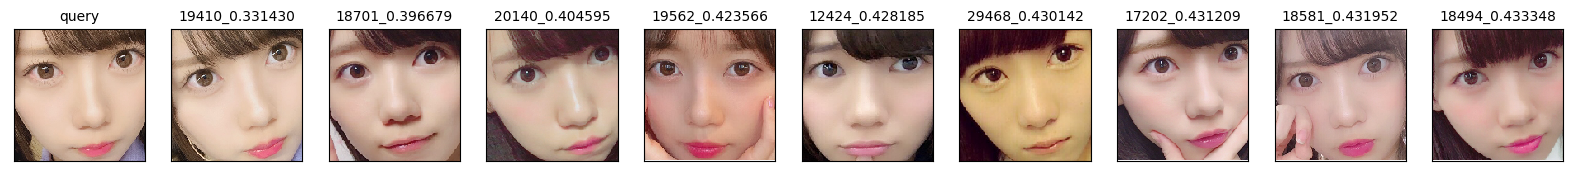

vgg16


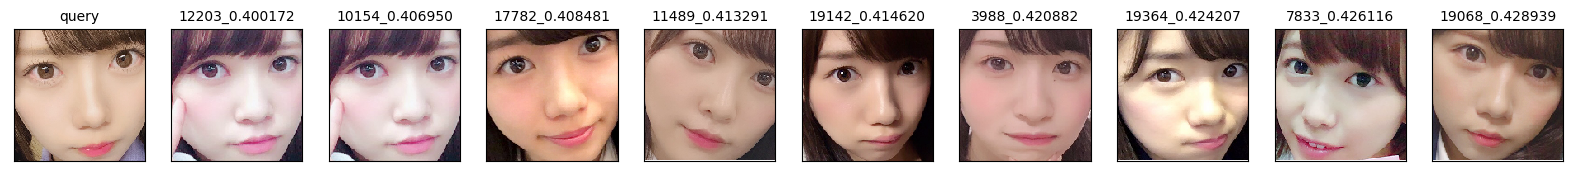

In [52]:
# ann test

from numpy.random import randint

def plot_test(k, images, dists):
    fig, ax = plt.subplots(ncols=k, figsize=(20,20), dpi=100)
    for i in range( k ): # search_k=-1
        im = Image.open( image_list[images[i]] )
        im_list = np.asarray(im)
        if i == 0:
            ax[i].set_title('query', fontsize=10 )
        else:
            ax[i].set_title('%s_%f'%(images[i], dists[i]), fontsize=10 )
        ax[i].tick_params(labelbottom=False,bottom=False)
        ax[i].tick_params(labelleft=False,left=False)
        ax[i].imshow(im_list)
    plt.show()

n = 1
k = 10
for target in randint(0, len(X_vgg), n):
    print( target )
    print( "facenet" ) 
    images, dists = t_face.get_nns_by_item(target, k, include_distances=True) # search_k=-1
    plot_test( k, images, dists )
    print( "vgg16" ) 
    images, dists = t_vgg.get_nns_by_item(target, k, include_distances=True) # search_k=-1
    plot_test( k, images, dists )

In [ ]:
# facenet

cn = 20

target_name = 'watanaberisa'
targets = [ i for i in range( len( image_list ) ) if image_author[i] == target_name ]

# reduce by pca
dim = 100
pca = PCA(n_components=dim); pca.fit( X_face[targets])
X_face_r = pca.fit_transform( X_face[targets] )

# clustering 
gmm = GaussianMixture(n_components=cn,covariance_type='full')
z_gmm = gmm.fit( X_face_r )
cluster = z_gmm.predict( X_face_r )
group = get_groups_with_dist_from_center( cluster, X_face_r, gmm )

# plot image scatter
Xr = TSNE(n_components=2, perplexity=8, random_state=1).fit_transform( X_face[targets] )
X_tmp = Xr

colors = cm.tab20.colors
fig, ax = plt.subplots(figsize=(40,20), dpi=200)
for i, im_idx in enumerate(targets):
    img = plt.imread( image_list[im_idx], format='jpg')
    # img = plt.imread(image_list[im_idx], format='jpg')
    imagebox = OffsetImage(img, zoom=0.3)
    ab = AnnotationBbox(imagebox, Xr[i], pad=0.1, bboxprops=dict(edgecolor=colors[ cluster[i] ] ) )
    ax.add_artist(ab)

max_x, min_x = max(Xr[:,0]), min(Xr[:,0])
max_y, min_y = max(Xr[:,1]), min(Xr[:,1])
ax.set_xlim([ min_x, max_x ])
ax.set_ylim([ min_y, max_y ])
plt.savefig('./results/image_scatter_facenet.png')
plt.show()

# plot images of each cluster
k = 8
for i in range( cn ):
    print( 'Cluster %d'%i )
    if len(group[i]) < k: plot_cluster(i, len(group[i]), group[i])
    else: plot_cluster(i, k, group[i])

In [ ]:
# vgg16

cn = 20

target_name = 'watanaberisa'
targets = [ i for i in range( len( image_list ) ) if image_author[i] == target_name ]

# reduce by pca
dim = 100
pca = PCA(n_components=dim); pca.fit( X_vgg[targets])
X_vgg_r = pca.fit_transform( X_vgg[targets] )

# clustering 
gmm = GaussianMixture(n_components=cn,covariance_type='full')
z_gmm = gmm.fit( X_vgg_r )
cluster = z_gmm.predict( X_vgg_r )
group = get_groups_with_dist_from_center( cluster, X_vgg_r, gmm )

# plot image scatter
Xr = TSNE(n_components=2, perplexity=8, random_state=1).fit_transform( X_vgg[targets] )
X_tmp = Xr

colors = cm.tab20.colors
fig, ax = plt.subplots(figsize=(40,20), dpi=200)
for i, im_idx in enumerate(targets):
    img = plt.imread(image_list[im_idx], format='jpg')
    imagebox = OffsetImage(img, zoom=0.3)
    ab = AnnotationBbox(imagebox, Xr[i], pad=0.1, bboxprops=dict(edgecolor=colors[ cluster[i] ] ) )
    ax.add_artist(ab)

max_x, min_x = max(Xr[:,0]), min(Xr[:,0])
max_y, min_y = max(Xr[:,1]), min(Xr[:,1])
ax.set_xlim([ min_x, max_x ])
ax.set_ylim([ min_y, max_y ])
plt.savefig('./results/image_scatter_vgg16.png')
plt.show()

# plot images of each cluster
k = 8
for i in range( cn ):
    print( 'Cluster %d'%i )
    if len(group[i]) < k: plot_cluster(i, len(group[i]), group[i])
    else: plot_cluster(i, k, group[i])